Expectation: random < no prediction < generic heuristic < model-specific heuristic < ML

expect that failure depends on
* age of drive (wear)
* manufacturer, model, batch

In [6]:
import pandas
print('pandas',pandas.__version__)
import glob
import pickle
import numpy
import datetime
import time
import matplotlib.pyplot as plt

pandas 0.23.4


# no predictions

for each day, count number of drives and number of failed drives

* TP=0
* TN=97.45%
* FP=0
* FN=2.55%

error rate = (FP+FN)/total=2.55 (lower is better)

In [7]:
df_np = pandas.read_csv('data_synthesized_from_csvs/failures_vs_drive_count_per_day.dat',delimiter=' ',header=None)
df_np.columns=['date in filename','number of failures','number of unique drives']
df_np['date']=df_np['date in filename'].apply(lambda x: datetime.datetime.strptime(x.split('_')[-1],'%Y-%m-%d'))
df_np.drop(['date in filename'], axis=1,inplace=True)
df_np['ratio of failures to count per day']=df['number of failures']/df['number of unique drives']
df_np.shape

(2092, 4)

In [8]:
df.head()

,number of failures,number of unique drives,date,ratio of failures to count per day
0,6,102094,2018-05-22,0.000059
1,3,100576,2018-06-13,0.000030
2,4,100064,2018-04-30,0.000040
3,6,100529,2018-06-14,0.000060
4,6,101864,2018-05-25,0.000059


In [17]:
df_np['TP drive predicted to be removed is removed']=0
df_np['TN drive expected to work continues to work']=df_np['number of unique drives']-df_np['number of failures']
df_np['FP drive predicted to be removed is not removed']=0
df_np['FN drive expected to work is removed']=df_np['number of failures']

df_np['overall error rate in %'] = 100.0*((df_np['FP drive predicted to be removed is not removed']+df_np['FN drive expected to work is removed'])/df_np['number of unique drives'])

df_np.head()

,number of failures,number of unique drives,date,ratio of failures to count per day,TP drive predicted to be removed is removed,TN drive expected to work continues to work,FP drive predicted to be removed is not removed,FN drive expected to work is removed,overall error rate,overall error rate in %
0,6,102094,2018-05-22,0.000059,0,102088,0,6,0.000059,0.005877
1,3,100576,2018-06-13,0.000030,0,100573,0,3,0.000030,0.002983
2,4,100064,2018-04-30,0.000040,0,100060,0,4,0.000040,0.003997
3,6,100529,2018-06-14,0.000060,0,100523,0,6,0.000060,0.005968
4,6,101864,2018-05-25,0.000059,0,101858,0,6,0.000059,0.005890


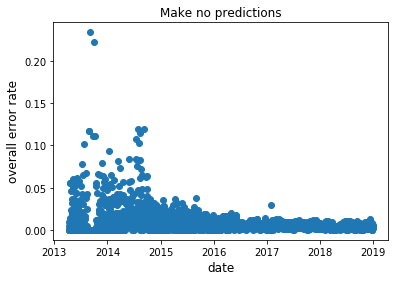

In [18]:
plt.plot_date(x=df_np['date'],y=df_np['overall error rate in %'])
plt.title('Make no predictions',fontsize=12)
plt.xlabel('date',fontsize=12)
plt.ylabel('overall error rate',fontsize=12);

# random prediction

"in the next three days, this drive will be removed"
* drive could be removed tomorrow (today+1)
* drive could be removed today+2
* drive could be removed today+3


for each day, get list of drives

from that list, select `(random_failure_rate)*len(list_of_drives)` to be removed.

* TP=0
* TN=92.5
* FP=4.9
* FN=2.57

overall error rate = (FP+FN)/total = 7.5


In [19]:
daily_failure_rate=10.0/100000.0

df_rp = pandas.read_csv('data_synthesized_from_csvs/failures_vs_drive_count_per_day.dat',delimiter=' ',header=None)
df_rp.columns=['date in filename','number of failures','number of unique drives']
df_rp['date']=df_np['date in filename'].apply(lambda x: datetime.datetime.strptime(x.split('_')[-1],'%Y-%m-%d'))
df_rp.drop(['date in filename'], axis=1,inplace=True)
df_rp.shape

In [ ]:
df_rp['TP drive predicted to be removed is removed']=0
df_rp['TN drive expected to work continues to work']=df_np['number of unique drives']-df_np['number of failures']
df_rp['FP drive predicted to be removed is not removed']=0
df_rp['FN drive expected to work is removed']=df_np['number of failures']

df_np['overall error rate in %'] = 100.0*((df_np['FP drive predicted to be removed is not removed']+df_np['FN drive expected to work is removed'])/df_np['number of unique drives'])

df_np.head()

# simple heuristic: measure exceeds threshold 

threshold_for_raw5=1000

prediction_window_in_days=3

for each drive, if raw5>1000, then predict that in the next 3 days the drive will fail

tp_drive_predicted_to_be_removed_is_removed=0
tn_drive_expected_to_work_continues_to_work=0
fp_drive_predicted_to_be_removed_is_not_removed=0
fn_drive_expected_to_work_is_removed=0


* TP=0.13
* TN=97.3
* FP=0.039
* FN=2.49

overall error rate = 2.5
